<a href="https://colab.research.google.com/github/vadhri/distibuted-optimization/blob/main/graph_consensus/uncapacitated_capacitated_edp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install igraph

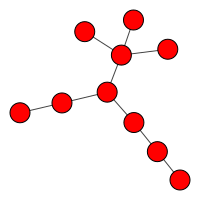

In [ ]:
# have an electric power grid modelled as a graph, with N nodes and N-1 edges

import igraph as ig
N = 10

# create a random graph using N nodes and N-1 edges
g = ig.Graph.Erdos_Renyi(n=N, m=N-1, directed=False)

# plot the graph
ig.plot(g, bbox=(0,0,200,200))

In [ ]:
adj = g.get_adjacency()
adj

Matrix([[0, 0, 0, 1, 1, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, 1, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0, 1, 1, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 1, 0, 0, 0]])

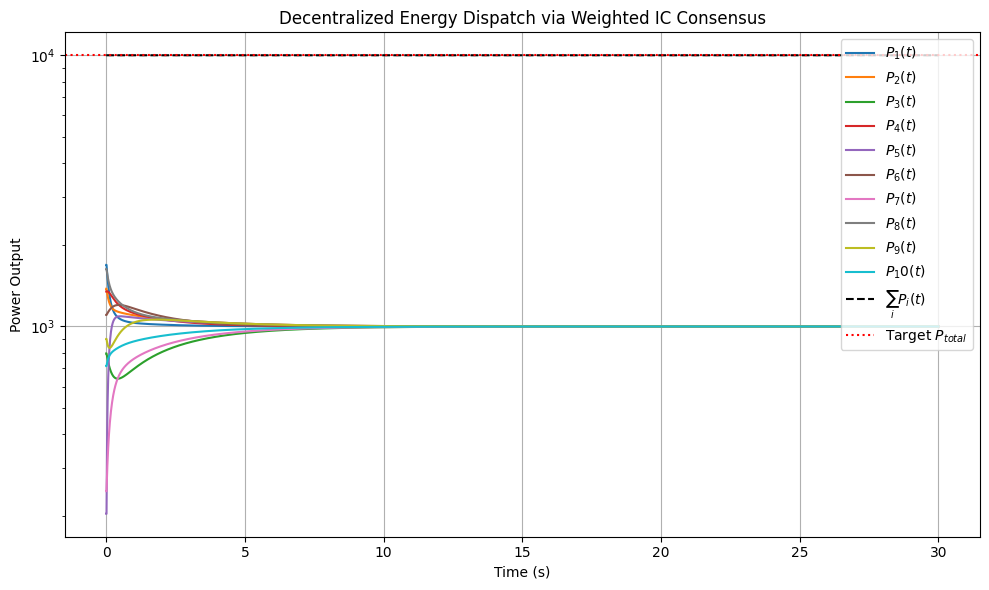

np.float64(9999.999999999996)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
T = 3000
dt = 0.01
c = 1.0  # control gain

# Total power demand
P_total = 10000.0

# Random cost function parameters
np.random.seed(0)
gamma = np.random.uniform(1, 5, size=N)
beta = np.random.uniform(0.5, 2.0, size=N)

# Assign initial power such that sum P_i = P_total
P_init = np.random.rand(N)
P_init = P_total * P_init / np.sum(P_init)  # normalize

# Initialize eta_i(0) using equation (14): eta_i = beta_i + 2 * gamma_i * P_i
eta = beta + 2 * gamma * P_init

# Fully connected undirected graph: adjacency matrix
A = g.get_adjacency()

# Weights: w_i = 1 / gamma_i
w = 1.0 / gamma


# Store history for plotting
P_hist = [P_init.copy()]
eta_hist = [eta.copy()]

# Run simulation
for _ in range(T):
    # Compute current P_i(t)
    P = (eta - beta) / (2 * gamma)

    # Update eta using equation (17)
    eta_dot = np.zeros(N)
    for i in range(N):
        for j in range(N):
            if A[i, j] == 1:
                eta_dot[i] += 2 * c * gamma[i] * (w[i] * eta[i] - w[j] * eta[j])
    eta = eta - dt * eta_dot  # Integrate

    # Log
    P_hist.append(P.copy())
    eta_hist.append(eta.copy())

# Convert history to arrays
P_hist = np.array(P_hist)
eta_hist = np.array(eta_hist)
time = np.arange(T + 1) * dt

# Plotting
plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(time, P_hist[:, i], label=f'$P_{i+1}(t)$')
plt.plot(time, np.sum(P_hist, axis=1), 'k--', label='$\sum_i P_i(t)$')
plt.axhline(P_total, color='red', linestyle='dotted', label='Target $P_{{total}}$')
plt.xlabel('Time (s)')
plt.ylabel('Power Output')
# set log scale on Y axis
plt.yscale('log')
plt.title('Decentralized Energy Dispatch via Weighted IC Consensus')
# set legend on the top right corner
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Final total power
final_total_power = np.sum(P_hist[-1])
final_total_power


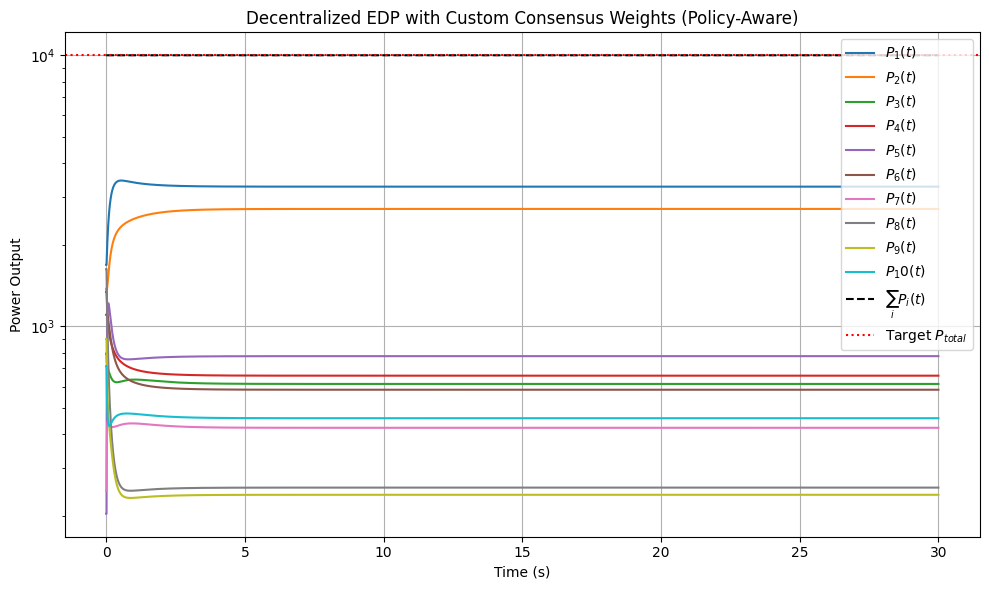

(array([3277.43164829, 2712.53085738,  613.86842798,  658.48351467,
         777.21958296,  584.41581106,  423.00427832,  254.60402953,
         239.53129988,  458.91054993]),
 np.float64(10000.000000000011))

In [ ]:
# Re-run after kernel reset

import numpy as np
import matplotlib.pyplot as plt
import igraph as ig

# Number of nodes (generators/reactors)

# Total power demand
P_total = 10000.0

# Simulation parameters
T = 3000
dt = 0.01
c = 1.0  # control gain

# Random cost function parameters
np.random.seed(0)
gamma = np.random.uniform(1, 5, size=N)  # cost curvature
beta = np.random.uniform(0.5, 2.0, size=N)  # linear cost

# Initial power allocation such that sum P_i = P_total
P_init = np.random.rand(N)
P_init = P_total * P_init / np.sum(P_init)  # normalize to total

# Initial eta based on cost function
eta = beta + 2 * gamma * P_init

# Build fully connected undirected graph
A = np.array(g.get_adjacency().data)

# Custom weights: decoupled from gamma
# Favor node 0 and 1 (e.g., greener reactors)
w = np.array([1.0, 1.0, 5.0, 5.0, 5.0, 5.0, 9.0, 9.0, 9.0, 9.0])  # policy-driven weights

# Create Metropolis-Hastings weights for consensus matrix
degree = np.sum(A, axis=1)
W = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if A[i, j] == 1:
            W[i, j] = 1 / (1 + max(degree[i], degree[j]))
    W[i, i] = 1 - np.sum(W[i])  # make rows sum to 1

# Store history
P_hist = [P_init.copy()]
eta_hist = [eta.copy()]

# Simulation loop
for _ in range(T):
    # Local power update using optimality condition
    P = (eta - beta) / (2 * gamma)

    # Consensus update of eta (weighted IC)
    eta_dot = np.zeros(N)
    for i in range(N):
        for j in range(N):
            if A[i, j] == 1:
                eta_dot[i] += 2 * c * gamma[i] * W[i, j] * (w[i] * eta[i] - w[j] * eta[j])

    eta -= dt * eta_dot

    # Log values
    P_hist.append(P.copy())
    eta_hist.append(eta.copy())

# Convert logs
P_hist = np.array(P_hist)
eta_hist = np.array(eta_hist)
time = np.arange(T + 1) * dt

# Plot power output over time
plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(time, P_hist[:, i], label=f'$P_{i+1}(t)$')
plt.plot(time, np.sum(P_hist, axis=1), 'k--', label='$\\sum_i P_i(t)$')
plt.axhline(P_total, color='red', linestyle='dotted', label='Target $P_{{total}}$')
plt.xlabel('Time (s)')
plt.ylabel('Power Output')
plt.yscale('log')
plt.title('Decentralized EDP with Custom Consensus Weights (Policy-Aware)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final power output
final_P = P_hist[-1]
final_P, np.sum(final_P)


In [138]:
from math import pow
def sgn_func(power, value):
  return value*((np.abs(value)*1.0)**(power-1))

def pdot_update(mu1, mu2, i, g, eta_arr):
  neighbours = g.neighbors(i)
  v = 0.0

  for j in neighbours:
    diff = eta_arr[j] - eta_arr[i]
    v += sgn_func(mu1, diff) + sgn_func(mu2, diff)
  print("pdot = ", i, v)
  return v

sgn_func(0, -2)

np.float64(-1.0)

Initial p values: [2228.17292372 2903.65592333 2447.2084312  2212.21589165 1720.03084132
 2622.3184452  1776.59618235 3620.58229294 3912.45342029 1556.76564801], sum of p values = 25000.0
Final Power Output: [3396.06064908 3396.06064908 3394.37742159 3396.06064908 3396.06064908
 1720.4187091  1769.3391249  1814.77362882 1358.42425963 1358.42425963]
Final Total Power: 25000.0
Weights: [1. 1. 1. 1. 1. 2. 2. 2. 4. 4.]
Final P / Weight: [3396.06064908 3396.06064908 3394.37742159 3396.06064908 3396.06064908
  860.20935455  884.66956245  907.38681441  339.60606491  339.60606491]
pmin: [ 300.  300.  300.  300.  300.  600.  600.  600. 1200. 1200.]
pmax: [ 3000.  3000.  3000.  3000.  3000.  6000.  6000.  6000. 12000. 12000.]


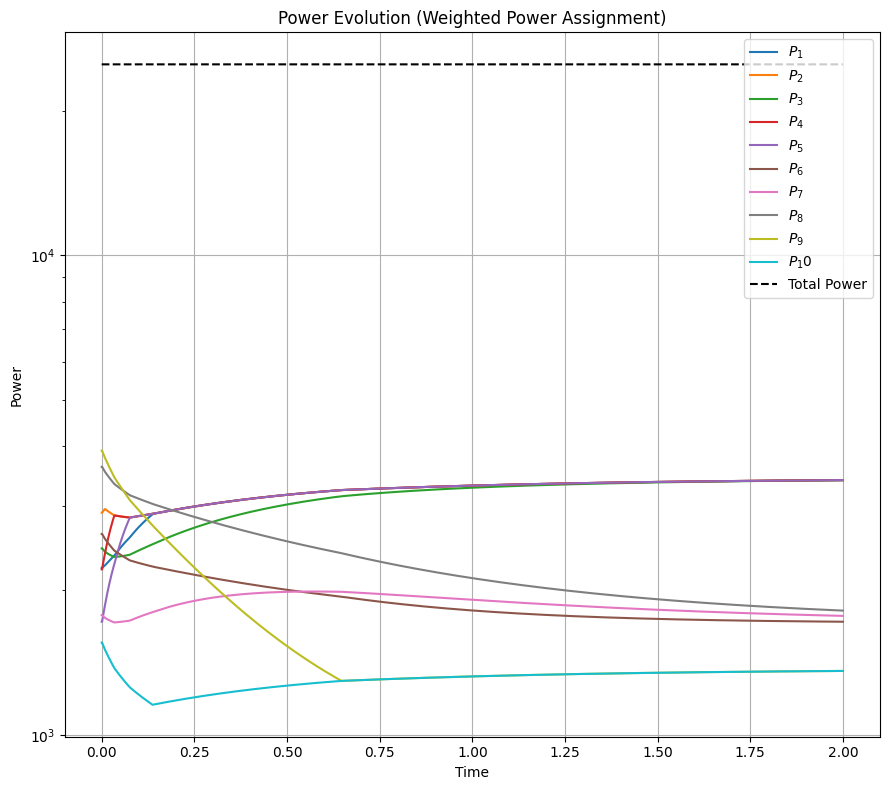

In [234]:
import numpy as np
import matplotlib.pyplot as plt
import igraph as ig
from math import copysign

def sgn_func(power, value):
    # Cap value to prevent overflow
    value = np.clip(value, -1e5, 1e5)
    if np.abs(value) < 1e-8:
        return 0.0
    return copysign(np.abs(value) ** power, value)

def pdot_update(mu1, mu2, i, g, eta_arr, weights):
    v = 0.0
    for j in g.neighbors(i):
        diff = weights[j] * eta_arr[j] - weights[i] * eta_arr[i]
        v += sgn_func(mu1, diff) + sgn_func(mu2, diff)
    return v / weights[i]  # Scale by weight for balance

# Setup
N = 10
T = 2000
dt = 0.001
mu1 = 1.0
mu2 = 1.0
P_total = 25000.0
weights = np.ones(N)
weights[5:] = 2.0
weights[8:] = 4.0

np.random.seed(0)
gamma = np.ones(N)  # Simplify gamma for stability
beta = np.zeros(N)  # Simplify beta
P_init = np.random.rand(N)
P_init = P_total * P_init / np.sum(P_init)
print(f'Initial p values: {P_init}, sum of p values = {sum(P_init)}')

eta = P_init  # Initialize eta proportional to P

# Define pmax and pmin based on weights
pmax = np.ones(N) * 3000  # Base max for weights=1.0
pmax[5:8] = 6000         # Higher max for weights=2.0
pmax[8:] = 12000         # Higher max for weights=4.0
pmin = np.ones(N) * 300   # Base min for weights=1.0
pmin[5:8] = 600          # Higher min for weights=2.0
pmin[8:] = 1200          # Higher min for weights=4.0

g = ig.Graph.Erdos_Renyi(n=N, m=2*N, directed=False)  # Denser graph

# Logs
P_hist = [P_init.copy()]
eta_hist = [eta.copy()]

# Simulation loop
for t in range(T):
    eta_dot = np.zeros(N)
    P = eta  # Simplified: P = eta (gamma=1, beta=0)
    P = np.clip(P, 0.1, 1e5)  # Prevent zero power

    for i in range(N):
        pdot = dt * pdot_update(mu1, mu2, i, g, eta, weights)
        eta_dot[i] = pdot  # Simplified update
        eta_dot[i] = np.clip(eta_dot[i], -1e3, 1e3)

    eta_new = eta + dt * eta_dot  # Compute new eta before clipping
    # Apply pmax and pmin only if out of bounds, adjust eta_dot
    for i in range(N):
        if eta_new[i] < pmin[i]:
            eta[i] = pmin[i]
            if eta_dot[i] < 0:  # Prevent further decrease
                eta_dot[i] = 0
        elif eta_new[i] > pmax[i]:
            eta[i] = pmax[i]
            if eta_dot[i] > 0:  # Prevent further increase
                eta_dot[i] = 0
        else:
            eta[i] = eta_new[i]  # Apply unconstrained update

    # Update P and enforce total power conservation
    P = eta  # P = eta
    P = np.clip(P, 0.1, 1e5)
    if np.sum(P) > 0:
        P = P_total * P / np.sum(P)

    # Consensus on eta values
    eta_new = eta.copy()
    for i in range(N):
        eta_sum = 0.0
        for j in g.neighbors(i):
            diff = (eta[j] * weights[j]) - (eta[i] * weights[i])
            eta_sum += sgn_func(mu1, diff) / weights[i]
        eta_new[i] += dt * eta_sum
    eta = np.clip(eta_new, 0.1, 1e5)

    P_hist.append(P.copy())
    eta_hist.append(eta.copy())

# Convert logs
P_hist = np.array(P_hist)
eta_hist = np.array(eta_hist)
time = np.arange(T + 1) * dt

# Final output
final_P = P_hist[-1]
print("Final Power Output:", final_P)
print("Final Total Power:", np.sum(final_P))
print("Weights:", weights)
print("Final P / Weight:", final_P / weights)
print("pmin:", pmin)
print("pmax:", pmax)

# Plot
plt.figure(figsize=(9, 8))
P_hist = np.nan_to_num(P_hist, nan=0.0, posinf=1e5, neginf=0.0)
for i in range(N):
    plt.plot(time, P_hist[:, i], label=f'$P_{i+1}$')
plt.plot(time, np.sum(P_hist, axis=1), 'k--', label='Total Power')
plt.legend(loc='upper right')
plt.xlabel("Time")
plt.ylabel("Power")
plt.yscale('log')
plt.title("Power Evolution (Weighted Power Assignment)")
plt.grid(True)
plt.tight_layout()
plt.show()

Initial p values: [2228.17292372 2903.65592333 2447.2084312  2212.21589165 1720.03084132
 2622.3184452  1776.59618235 3620.58229294 3912.45342029 1556.76564801], sum of p values = 25000.0
Final Power Output: [3000.         3000.         3000.         3000.         3000.
 2624.31831332 2595.08328858 2327.40033198 1252.40633292 1200.0586469 ]
Final Total Power: 24999.266913707477
Weights: [1. 1. 1. 1. 1. 3. 3. 3. 8. 8.]
Final P / Weight: [3000.         3000.         3000.         3000.         3000.
  874.77277111  865.02776286  775.80011066  156.55079162  150.00733086]
pmin: [ 300.  300.  300.  300.  300.  600.  600.  600. 1200. 1200.]
pmax: [3000. 3000. 3000. 3000. 3000. 6000. 6000. 6000. 8000. 8000.]


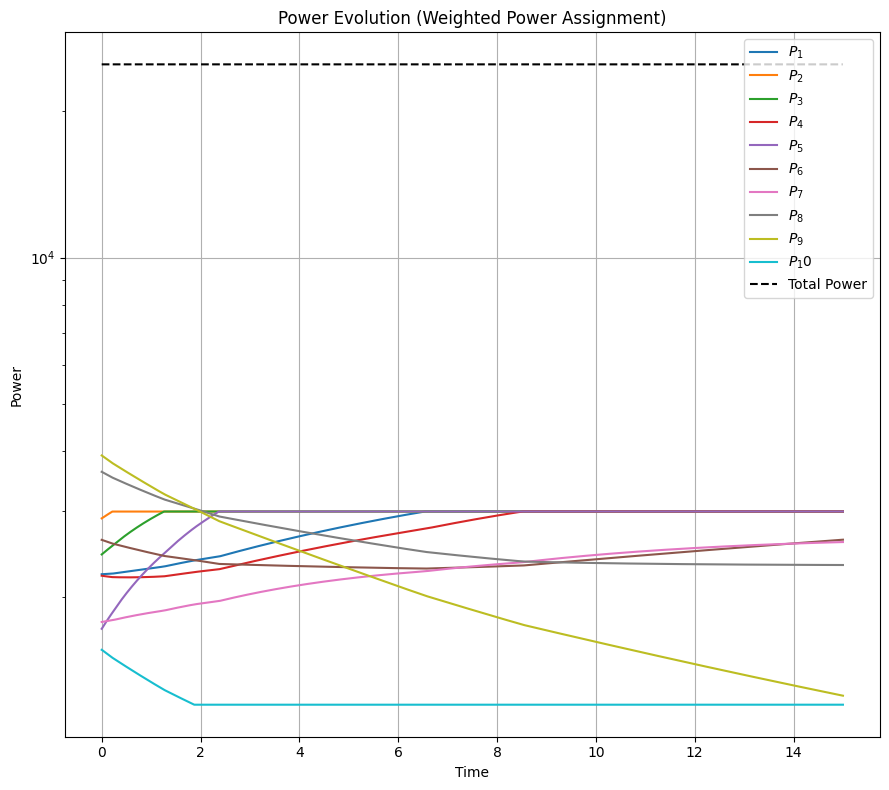

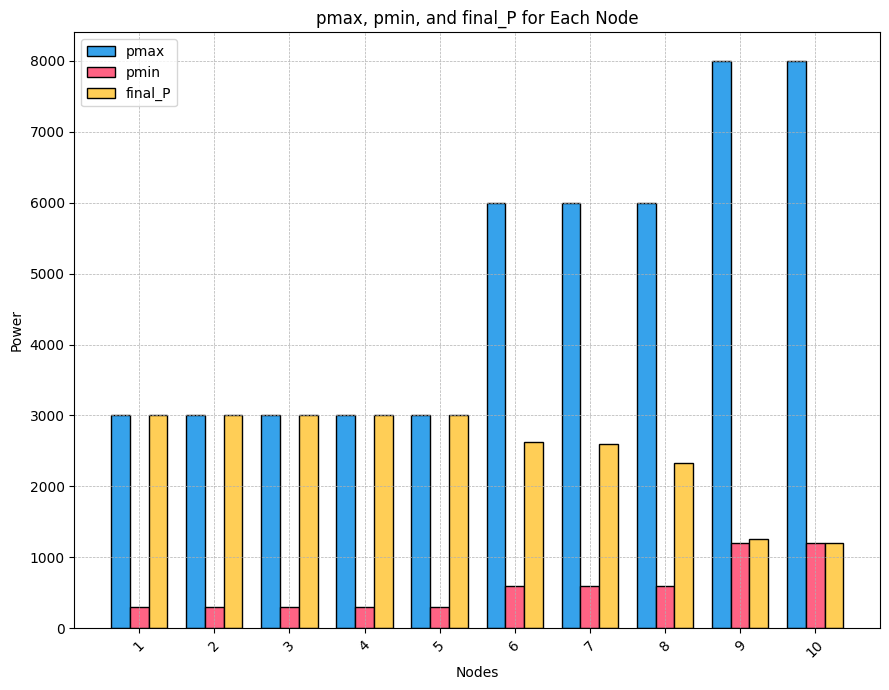

In [247]:
import numpy as np
import matplotlib.pyplot as plt
import igraph as ig
from math import copysign

def sgn_func(power, value):
    value = np.clip(value, -1e5, 1e5)
    if np.abs(value) < 1e-8:
        return 0.0
    return copysign(np.abs(value) ** power, value)

def pdot_update(mu1, mu2, i, g, eta_arr, weights):
    v = 0.0
    for j in g.neighbors(i):
        diff = weights[j] * eta_arr[j] - weights[i] * eta_arr[i]
        v += sgn_func(mu1, diff) + sgn_func(mu2, diff)
    return v / weights[i]  # Scale by weight for balance

# Setup
N = 10
T = 3000
dt = 0.005
mu1 = 0.5
mu2 = 1.1
P_total = 25000.0
weights = np.ones(N)
weights[5:] = 3.0
weights[8:] = 8.0

np.random.seed(0)
gamma = np.ones(N)  # Simplify gamma for stability
beta = np.zeros(N)  # Simplify beta
P_init = np.random.rand(N)
P_init = P_total * P_init / np.sum(P_init)
print(f'Initial p values: {P_init}, sum of p values = {sum(P_init)}')

eta = P_init  # Initialize eta proportional to P

# Define pmax and pmin based on weights
pmax = np.ones(N) * 3000  # Base max for weights=1.0
pmax[5:8] = 6000         # Higher max for weights=2.0
pmax[8:] = 8000         # Higher max for weights=4.0
pmin = np.ones(N) * 300   # Base min for weights=1.0
pmin[5:8] = 600          # Higher min for weights=2.0
pmin[8:] = 1200          # Higher min for weights=4.0

g = ig.Graph.Erdos_Renyi(n=N, m=N+5, directed=False)  # Denser graph

# Logs
P_hist = [P_init.copy()]
eta_hist = [eta.copy()]

# Simulation loop
for t in range(T):
    eta_dot = np.zeros(N)
    P = eta  # Simplified: P = eta (gamma=1, beta=0)
    P = np.clip(P, 0.1, 1e5)  # Prevent zero power

    for i in range(N):
        pdot = dt * pdot_update(mu1, mu2, i, g, eta, weights)
        eta_dot[i] = pdot  # Simplified update
        eta_dot[i] = np.clip(eta_dot[i], -1e3, 1e3)

    eta_new = eta + dt * eta_dot  # Compute new eta before clipping
    # Apply pmax and pmin only if out of bounds, adjust eta_dot
    for i in range(N):
        if eta_new[i] < pmin[i]:
            eta[i] = pmin[i]
            if eta_dot[i] < 0:  # Prevent further decrease
                eta_dot[i] = 0
        elif eta_new[i] > pmax[i]:
            eta[i] = pmax[i]
            if eta_dot[i] > 0:  # Prevent further increase
                eta_dot[i] = 0
        else:
            eta[i] = eta_new[i]  # Apply unconstrained update

    # Update P and enforce total power conservation
    P = eta  # P = eta
    P = np.clip(P, 0.1, 1e5)
    if np.sum(P) > 0:
        P = P_total * P / np.sum(P)  # Normalize after initial clipping

    # Re-clip P after normalization to enforce pmax/pmin
    P_clipped = P.copy()
    for i in range(N):
        if P_clipped[i] < pmin[i]:
            P_clipped[i] = pmin[i]
        elif P_clipped[i] > pmax[i]:
            P_clipped[i] = pmax[i]
    P = P_clipped  # Update P with clipped values

    # Adjust eta to match clipped P (since P = eta)
    eta = P

    # Consensus on eta values
    eta_new = eta.copy()
    for i in range(N):
        eta_sum = 0.0
        for j in g.neighbors(i):
            diff = (eta[j] * weights[j]) - (eta[i] * weights[i])
            eta_sum += sgn_func(mu1, diff) / weights[i]
        eta_new[i] += dt * eta_sum
    eta = np.clip(eta_new, 0.1, 1e5)

    P_hist.append(P.copy())
    eta_hist.append(eta.copy())

# Convert logs
P_hist = np.array(P_hist)
eta_hist = np.array(eta_hist)
time = np.arange(T + 1) * dt

# Final output
final_P = P_hist[-1]
print("Final Power Output:", final_P)
print("Final Total Power:", np.sum(final_P))
print("Weights:", weights)
print("Final P / Weight:", final_P / weights)
print("pmin:", pmin)
print("pmax:", pmax)

# Plot
plt.figure(figsize=(9, 8))
P_hist = np.nan_to_num(P_hist, nan=0.0, posinf=1e5, neginf=0.0)
for i in range(N):
    plt.plot(time, P_hist[:, i], label=f'$P_{i+1}$')
plt.plot(time, np.sum(P_hist, axis=1), 'k--', label='Total Power')
plt.legend(loc='upper right')
plt.xlabel("Time")
plt.ylabel("Power")
plt.yscale('log')
plt.title("Power Evolution (Weighted Power Assignment)")
plt.grid(True)
plt.tight_layout()
plt.show()

# create a 2d bar plot of pmax, pmin and final_P

# Set the width of the bars
bar_width = 0.25
index = np.arange(N)

# Create the bar plot
plt.figure(figsize=(9, 7))
plt.bar(index, pmax, bar_width, label='pmax', color='#36A2EB', edgecolor='black')
plt.bar(index + bar_width, pmin, bar_width, label='pmin', color='#FF6384', edgecolor='black')
plt.bar(index + 2 * bar_width, final_P, bar_width, label='final_P', color='#FFCE56', edgecolor='black')

# Customize the plot
plt.xlabel('Nodes')
plt.ylabel('Power')
plt.title('pmax, pmin, and final_P for Each Node')
plt.xticks(index + bar_width, list(range(1, N+1)), rotation=45)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()



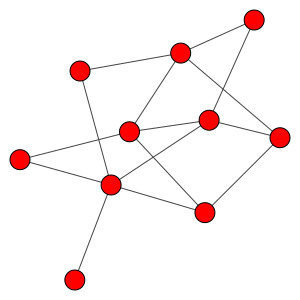

In [248]:
ig.plot(g, bbox=(0, 0, 300, 300))